# Starbucks Capstone Challenge

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [496]:
import pandas as pd
import numpy as np
#import math
#import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

%matplotlib inline

# 1) Data Understanding & Data Wrangling

## 1a) Data Gathering

In [497]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1b) Portfolio dataset

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [498]:
portfolio.head(5)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [499]:
#overview of NaNs and data types
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [500]:
#check if all offer ids are unique
if portfolio.id.nunique() == 10: 
    print('All offer ids are unique')
else:
    print('There are duplicates in the offer ids')

All offer ids are unique


**Conclusion:**
* The portfolio dataset has no missing values and the id is unique. 
* Seperate the values in the column "channels" (stored as a list) and store it in seperate columns (One-Hot-Encoding) for a better access.
* For a better understanding and data handling the column "difficulty" could be renamed to "minimum_spend" and the "id" to "offer_id"

**Data Cleaning**
* Split the column channels into the 4 types email, web, mobile, social and dummy them
* Rename the column id to offer_id for better undestanding
* Rename the column duration in duration_days for better understanding
* Rename the column difficulty in minimum_spend

In [501]:
#copy the dataframe
portfolio_cleansed = portfolio.copy()

#rename the columns
portfolio_cleansed = portfolio_cleansed.rename(columns={'id':'offer_id', 'difficulty':'minimum_spent','duration':'duration_days'})

#split and dummy the column channels
#see also https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
dummies = pd.get_dummies(portfolio_cleansed.channels.apply(pd.Series).stack(),prefix='channel', prefix_sep='_').groupby(level=0).sum()

#concat the dummies to the original dataframe
portfolio_cleansed = pd.concat([portfolio_cleansed, dummies], axis=1)

#delete the no more needed column channels
portfolio_cleansed.drop(columns='channels', inplace = True)

portfolio_cleansed.head(20)

,reward,minimum_spent,duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


## 1c) Profile dataset

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [502]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [503]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [504]:

mis_val= len(profile[profile.isnull().any(axis=1)])
mis_val_percent = 100 * mis_val / len(profile)
print('The percentage of rows with minimum one missing value is:',mis_val_percent)


The percentage of rows with minimum one missing value is: 12.794117647058824


In [505]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

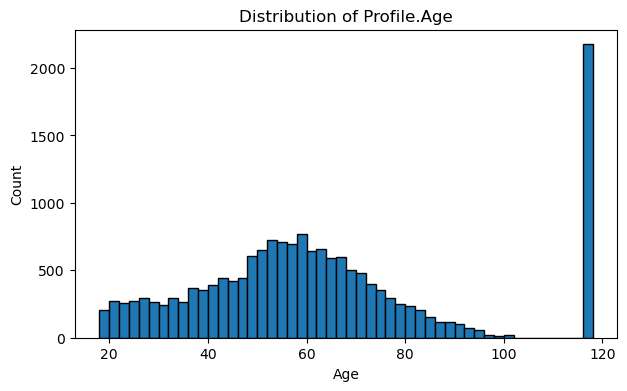

In [506]:
#check the age data visualy
plt.figure(figsize=(7,4))
plt.hist(profile.age,bins= 50,edgecolor = 'k')
plt.title('Distribution of Profile.Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show();

In [507]:
#have a deeper look into the rows with the age 118
profile[profile.age == 118].info()
# ==> All rows with an age of 118 have also missing date for gender and income. So these rows can be deleted.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      object 
 1   age               2175 non-null   int64  
 2   id                2175 non-null   object 
 3   became_member_on  2175 non-null   int64  
 4   income            0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [508]:
age_outliers_val= len(profile[profile.age == 118])
age_outlier_percent = 100 * age_outliers_val / len(profile)
print('The percentage of rows with an age of 118 is:',age_outlier_percent)

The percentage of rows with an age of 118 is: 12.794117647058824


In [509]:
age_outliners = profile[profile.age == 118]

In [510]:
gender_income_nan = profile[(profile.gender.isnull() & profile.income.isnull())]
gender_income_nan.id.equals(age_outliners.id)

True

**Observation:** 
There is an outlier in the age at 118 years. The rows with the age outlier also contains all NaNs for gender and income. 

In [511]:
profile.income.info()

<class 'pandas.core.series.Series'>
RangeIndex: 17000 entries, 0 to 16999
Series name: income
Non-Null Count  Dtype  
--------------  -----  
14825 non-null  float64
dtypes: float64(1)
memory usage: 132.9 KB


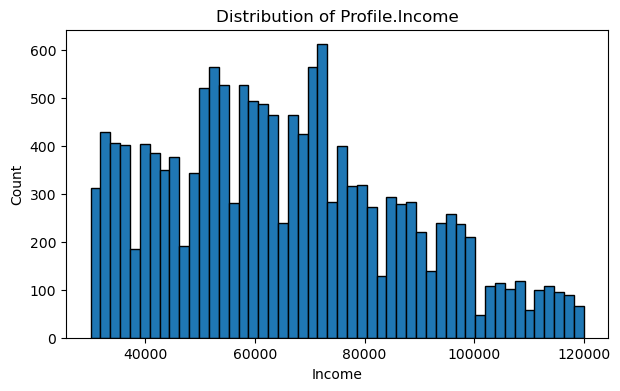

In [512]:
#check the income data visualy
plt.figure(figsize=(7,4))
plt.hist(profile.income,bins= 50,edgecolor = 'k')
plt.title('Distribution of Profile.Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show();

In [513]:
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

**Observation:** 
The income shows no outliers. The NaNs in the income are al connected to the outlier in the age.

In [514]:
profile.gender.dropna().value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [515]:
# Get the percentage of the different genders
np.round(100*profile.gender.value_counts(normalize=True),1)

M    57.2
F    41.3
O     1.4
Name: gender, dtype: float64

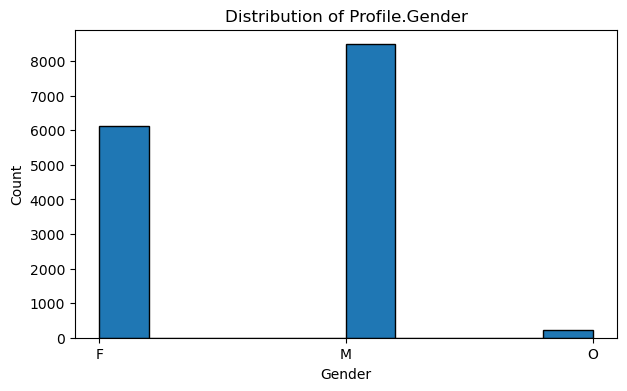

In [516]:
#check the age data visualy
plt.figure(figsize=(7,4))
plt.hist(profile.gender.dropna(),edgecolor = 'k')
plt.title('Distribution of Profile.Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show();

**Observation:** There are 3 types of gender: (M)ale, (F)emale and (O)thers in the dataset, coded with M, F and O. 51% are male, 41% female and 1.4% are others

In [517]:
#check if all ids are unique
if profile.id.nunique() == len(profile):
    print('All users in the dataset are unique')
else:
    print('There are duplicated users')

All users in the dataset are unique


**Conclusion:** 
* There are some NaNs in the Gender and Income columns. One possible way of cleaning is to delete these rows. However, 12% of the data will be lost.
* Exactly these rows have an outlier of 118 years in the age field. So in these rows 3 out of 4 data are not usable for the time being. Editing the missing and wrong data would not result in any usable data sets or rows. Therefore, deleting is the best way.
* To use the data in the gender column for modeling, dummies must be created.
* For a simpler evaluation of the data and more targeted statements, the individual persons are assigned to age classes. This results in an increased number of data points in the respective age group as a group compared to the grouping in year slices with regard to age, which is advantageous for modeling. See also https://absentdata.com/pandas/pandas-cut-continuous-to-categorical/
* The same applies to the duration of membership. Here, an assignment to year slices is made, which increases the number of data points in the group compared to a day-by-day view.
* To ensure consistency in the datasets, the column id should be called customer_id

**Data Cleaning**
* Cut all data above the age of 117 years
* Rename the column id to customer_id
* group the data into bins with the year, in which the person became am member
* group the data into bins of age. The bins are in 10 years except people below 30 and people above 80 due to the amount of data in these age classes.

In [518]:
#copy the dataframe
profile_cleansed = profile.copy()

#cut all rows with an age greater 1170, this deletes also all NaNs
profile_cleansed = profile_cleansed[profile_cleansed['age'] < 118]

#change to datetime format
profile_cleansed['became_member_on'] = pd.to_datetime(profile_cleansed['became_member_on'], format='%Y%m%d')

#rename the columns
profile_cleansed = profile_cleansed.rename(columns={'id':'customer_id'})

# create a new column with the year in wehich the person became a member and dele the colum becasme_member on
profile_cleansed['became_member_year'] = profile_cleansed['became_member_on'].apply(lambda x: x.year)
profile_cleansed.drop('became_member_on', axis=1, inplace = True)

#bin the age, see https://absentdata.com/pandas/pandas-cut-continuous-to-categorical/
profile_cleansed['age_bins'] = pd.cut(profile.age, bins=[17,29, 39, 49, 59, 69, 79, 117], 
                               labels=['-29', '30s', '40s', '50s', '60s', '70s','80+'])

profile_cleansed['income_bins'] = pd.cut(profile.income, bins=np.arange(20000,120000,10000), 
                               labels=['30-40Tsd', '40-50Tsd', '50-60Tsd', '60-70Tsd', '70-80Tsd', '80-90Tsd','90-100Tsd','100-110Tsd','110-120Tsd'])



In [519]:
profile_cleansed['income_bins'] = pd.cut(profile.income, bins=np.arange(29999,129999,10000), 
                               labels=['30-40Tsd', '40-50Tsd', '50-60Tsd', '60-70Tsd', '70-80Tsd', '80-90Tsd','90-100Tsd','100-110Tsd','110-120Tsd'])

## 1d) Transcript dataset

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [520]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [521]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [522]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

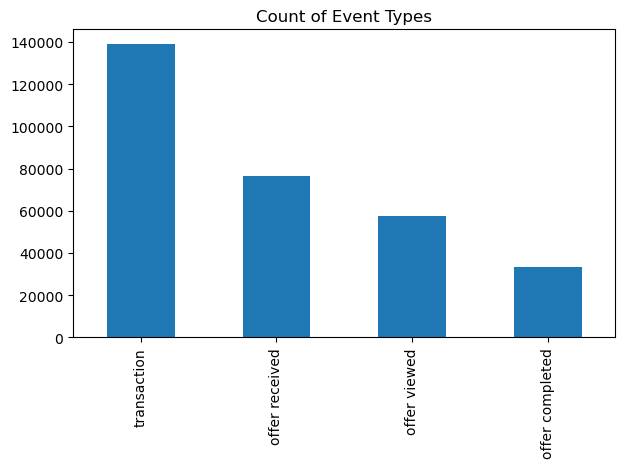

In [523]:
#check the event data visualy
transcript.event.value_counts().plot.bar(figsize=(7, 4),title="Count of Event Types");


**Observation:** Most of the events in the dataset are transaction

In [524]:
# View the data for the first person in the dataset
usr = transcript.loc[0]['person']
transcript[transcript.person == usr]

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


**Observation:** The transfer dataset stores the events for every person in a timelline. Therefore there are duplicates in the person column

In [525]:
# Deep Dive into the timeline
#split the dict of the column value into different columns,
# see https://www.skytowner.com/explore/splitting_dictionary_into_separate_columns_in_pandas_dataframe
transcript_cleansed = df = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript_cleansed.drop(columns='value',inplace = True)

In [526]:
# create a df group by person ans get the sum for amount and reward per person
grouped = transcript_cleansed.groupby('person').agg({'amount': 'sum', 'reward': 'sum'})

# caculate the ratio of reward to amount sums per person
grouped['ratio'] = grouped['reward'] / grouped['amount']

# test if there are any person where the sum of reward is higher than the sum of transactions.
# With the given portfolio this is not possible and seem to be an error in the data
to_much_df = pd.DataFrame(grouped[grouped.ratio > 1])
to_much_df.reset_index(inplace=True)
len(to_much_df)

7

**Obersevation:** There are 7 person with a ratio higher than 1 for the sum of reward to the sum of amount, which is not possible with the portfolio

In [527]:
# are there any people who never received an offer?
no_offer_df = transcript_cleansed.event

In [528]:
#copy the dataframe to have a backup in case of error when manipulation
transcript_split = transcript_cleansed.copy()

#sort first by person, then by time
transcript_split = transcript_split.sort_values(['person','time'])

#fill the NaNs in the order id column with the order_ids from the order_id column where availiable
transcript_split['offer id'].fillna(transcript_split['offer_id'], inplace=True)

#drop the column offer_id
transcript_split.drop(['offer_id'], axis=1, inplace=True)

#rename the column offer id to offer_id for later merging
transcript_split.rename(columns={'offer id': 'offer_id'}, inplace=True)

#get a unique list of all persons
person_list = transcript_split.person.drop_duplicates().to_list()

#get a list of offer ids for informational offers
informational_offer_id_list = portfolio_cleansed[portfolio_cleansed.offer_type == 'informational'].offer_id.to_list()

#get a unique list of all persons that received an informational offer
person_informational_list = transcript_split[transcript_split.offer_id.isin(informational_offer_id_list)].person.drop_duplicates().to_list()

#with the list of unique persons, who all received an informational offer, dive into some single persons
#get one dedicated person
single_person = person_informational_list[:1]
#filter the rows for this persons
single_person_df = transcript_split[transcript_split.person.isin(single_person)]

#for a better understanding enrich the offer actions with the offer type
single_person_df = pd.merge(single_person_df,portfolio_cleansed[['offer_id','offer_type']],on='offer_id', how='left')

single_person_df.head(30)


,person,event,time,offer_id,amount,reward,offer_type
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
2,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
5,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,bogo
6,0009655768c64bdeb2e877511632db8f,transaction,414,NaN,8.57,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,bogo
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,bogo
9,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,discount


**Oberservation:** There are offers that are completed and the viewing is after completion. Also there are orders that are completed without viewing

In [529]:
#Look to another dedicated person
single_person = person_informational_list[1:2]
#filter the rows for this persons
single_person_df = transcript_split[transcript_split.person.isin(single_person)]

#for a better understanding enrich the offer actions with the offer type
single_person_df = pd.merge(single_person_df,portfolio_cleansed[['offer_id','offer_type']],on='offer_id', how='left')

single_person_df.head(30)

,person,event,time,offer_id,amount,reward,offer_type
0,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
1,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,6,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
2,0011e0d4e6b944f998e987f904e8c1e5,transaction,132,NaN,13.49,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,discount
4,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,186,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,discount
5,0011e0d4e6b944f998e987f904e8c1e5,transaction,252,NaN,11.93,NaN,NaN
6,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,discount
7,0011e0d4e6b944f998e987f904e8c1e5,offer received,336,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
8,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,354,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
9,0011e0d4e6b944f998e987f904e8c1e5,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,discount


**Observation:** The above data  show that 2 offers (here discount and bogo) can be active at the same time. the 2 offers from timestamp 408 and 504 are closed at the same time when the cumulative transaction amount exceeds the threshold resulting from the minimum amount of the two offers.
However, this also means that transactions and their totals cannot be assigned 1:1 to individual offers. This is only the case if only one offer is active. As soon as several offers are active, transactions always pay on all active ones and the cumulative sum minus the minimum turnover of offers closed in between is relevant for the successful closing of the next offer. From the timeline it is also not clear which principle is used for closing, e.g. FIFO or as soon as the lowest threshold is exceeded.

**Conclusion:**
* There are no NaNs in the dataset. 
* The transcript dataset is like a timeline for the offer aktions offer received, offer viewed, offer completed inkl. reward and the transaction
* The example date for 2 dedicated persons show that there are different case for offer (completion):


**Informational offers:**
- offer received => offer viewed in between the valid time //sucessful informational offer
- offer received but not viewed in between the valid time //unsucessful informational offer

**BOGO and Discount offers:**
- offer received => offer viewed => transactions => offer completed // this is a successfull offer
- offer received => offer completed (without viewing) => uneffcient offer
- offer received => offer completed => offer viewed => also classified as unefficient offer because of possible customer confusion and
the transactions for offer completion where not made under the influence of the offer
- offer received and no further actions until the validtime of the offer ends => unsuccessful offer

* And of course there are also transaction without an active offer
* To access the data in the column value for visualisation and modeling the dict has to be stored in seperated columns
* More than one offer can be active. This leads to the situation that that a simple 1:1 relationship between offer and transaction is not possible. The relevant transactions are the cumulative transactions during the period of offer validity minus the minimum thresholds for the completed offers. Rules would need to be established here on how transactions are assigned to bids and then applied based on timestamps. However, this detailed analysis is more relevant to the question of how effective individual offers are.
* For the current consideration, simple ratios between total transaction amounts, minimum thresholds of offers and rewards can be used.


**Data Cleaning and Preperaion**
* the original transcipt df dict of the value column was already splitted into different columns, see code above
* delete all persons with a reward/amount ratio greater 1
* delete the row for all person which are not in the profile_cleansed dataset
* extract the total amount and reward per person and store it in a dataframe
* drop all rows with NaN in the column offer_id => drop all rows with transaction
* drop the no further needed columns amount and reward (the sums per perdson are now stored in the transactions dataframe)
* merge the offer_type and duration days from the portfolio dfto the transcipt_split df
* calculate the valid time in days refering to the time column for each row (only the value from the row with offer received is realy needed, the other vaues are not valid)
* get the offer actions for each person
* check if the offers are successful offers as claimed above
* store the results in a dataframe

In [530]:
transcript_split.head()
to_much_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   person  7 non-null      object 
 1   amount  7 non-null      float64
 2   reward  7 non-null      float64
 3   ratio   7 non-null      float64
dtypes: float64(3), object(1)
memory usage: 352.0+ bytes


In [531]:
#delete persons with impossible reward/amount ratio > 1
transcript_split = transcript_split.drop(transcript_split[transcript_split.person.isin(to_much_df.person)].index)

In [532]:
# delete all rows from transcript_split that have no correspondent customer_id in the cleaned profile df
transcript_split = transcript_split[transcript_split['person'].isin(profile_cleansed['customer_id'])]

In [533]:
#get the transaction amount and reward per person as sum
transactions_df = transcript_split.groupby('person')[['amount','reward']].sum()
transactions_df = transactions_df.reset_index()
transactions_df = transactions_df.rename(columns={'person': 'customer_id'})

In [534]:
#clean the transcript_split df for further analysis
#delete all rows with transactions => offer_id = NaN
transcript_split.dropna(subset = ['offer_id'], inplace=True)

#drop the columns amount and award
transcript_split.drop(columns =['amount', 'reward'], inplace=True)

#add the information of the offer type to the dataframe
transcript_split = pd.merge(transcript_split,portfolio_cleansed[['offer_id','offer_type']],on='offer_id', how='left')

#add the information of the duration to the dataframe
transcript_split = pd.merge(transcript_split,portfolio_cleansed[['offer_id','duration_days']],on='offer_id', how='left')

# calculate how long the offer is valid an store the result in an extra column
transcript_split['valid_until'] = transcript_split.apply(lambda row: row.time + (row.duration_days * 24), axis = 1)

offer received => offer viewed => transactions => offer completed // this is a successfull offer
- offer received => offer completed (without viewing) => uneffcient offer
- offer received => offer completed => offer viewed => also classified as unefficient offer because of possible customer confusion and
the transactions for offer completion where not made under the influence of the offer
- offer received and no further actions until the validtime of the offer ends => unsuccessful offer

In [535]:
# extract the offers and check if the offer is successful or not
# and store the results in an new df 

# list for creatin dataframe columns
person_col = []
offer_id_col = []
success_col = []

# patterns of successful offers
pattern_informational = ['offer received', 'offer viewed']
pattern_bogo_discount = ['offer received', 'offer viewed','offer completed']

# get a list off all unique persons
person_list = transcript_split.person.drop_duplicates().to_list()

# create a df groupe by person
grouped = transcript_split.groupby('person')

#loop through al unique person
for p in person_list: 

    # get a dataframe with al actions for the actual person p
    person_df = grouped.get_group(p) 

    # loop through all rows of the person specific dataframe
    for index,row in person_df.iterrows():

        # check if the row holds the data for an offer receive 
        if row.event == 'offer received':

            #get the time until the offer is valid
            validity = row.valid_until

            # get the data for offer_id, time for offfer received action 
            # and the offer type (informational, discount or bogo)
            of_id = row.offer_id
            rt = row.time
            r_type = row.offer_type
            
            # filter the rows with the offer_id in between the time in which the offer is valid 
            filter_df = person_df.query("offer_id == @of_id & time >= @rt & time <= @validity") 

            # get the pattern of the offer actions, e.g. received / viewed / completed
            act_pattern = filter_df.event.to_list()

            # check if the offer pattern is equal to a pattern for a successfull offer
            if ((filter_df.offer_type.values[0] == 'bogo') or  (filter_df.offer_type.values[0] == 'discount')):
                offer_success = (act_pattern == pattern_bogo_discount)
            
            if filter_df.offer_type.values[0] == 'informational':
                offer_success = (act_pattern == pattern_informational)
        
            # add the result to the column lists
            person_col.append(p)
            offer_id_col.append(of_id)
            success_col.append(offer_success) 
data = {'customer_id':person_col, 'offer_id':offer_id_col, 'success':success_col}
offer_df = pd.DataFrame(data)

                

## 1e) Bringing all data together - merge the datasets

In [536]:
portfolio_cleansed.head()
#transactions_df.head()

,reward,minimum_spent,duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [537]:
# remark: due to the offer_df is on the left side it does not matter if there are any persons who never received an offer
person_offer_df = pd.merge(offer_df,profile_cleansed[['customer_id','gender','age','age_bins','income','income_bins','became_member_year']],on='customer_id', how='left')
person_offer_df = pd.merge(person_offer_df,portfolio_cleansed[['offer_id','offer_type','reward','minimum_spent','duration_days','channel_email','channel_social','channel_mobile','channel_web']],on='offer_id', how='left')
transactions_df = pd.merge(transactions_df,profile_cleansed[['customer_id','gender','age','age_bins','income','became_member_year']],on='customer_id', how='left')

In [538]:
person_offer_df.head()

,customer_id,offer_id,success,gender,age,age_bins,income,income_bins,became_member_year,offer_type,reward,minimum_spent,duration_days,channel_email,channel_social,channel_mobile,channel_web
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,True,M,33,30s,72000.0,70-80Tsd,2017,informational,0,0,3,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,True,M,33,30s,72000.0,70-80Tsd,2017,informational,0,0,4,1,0,1,1
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,False,M,33,30s,72000.0,70-80Tsd,2017,bogo,5,5,5,1,1,1,1
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,False,M,33,30s,72000.0,70-80Tsd,2017,discount,2,10,10,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,False,M,33,30s,72000.0,70-80Tsd,2017,discount,2,10,7,1,0,1,1


## 2) Explanatory Data Analysis

#### Distrubution of gender by age

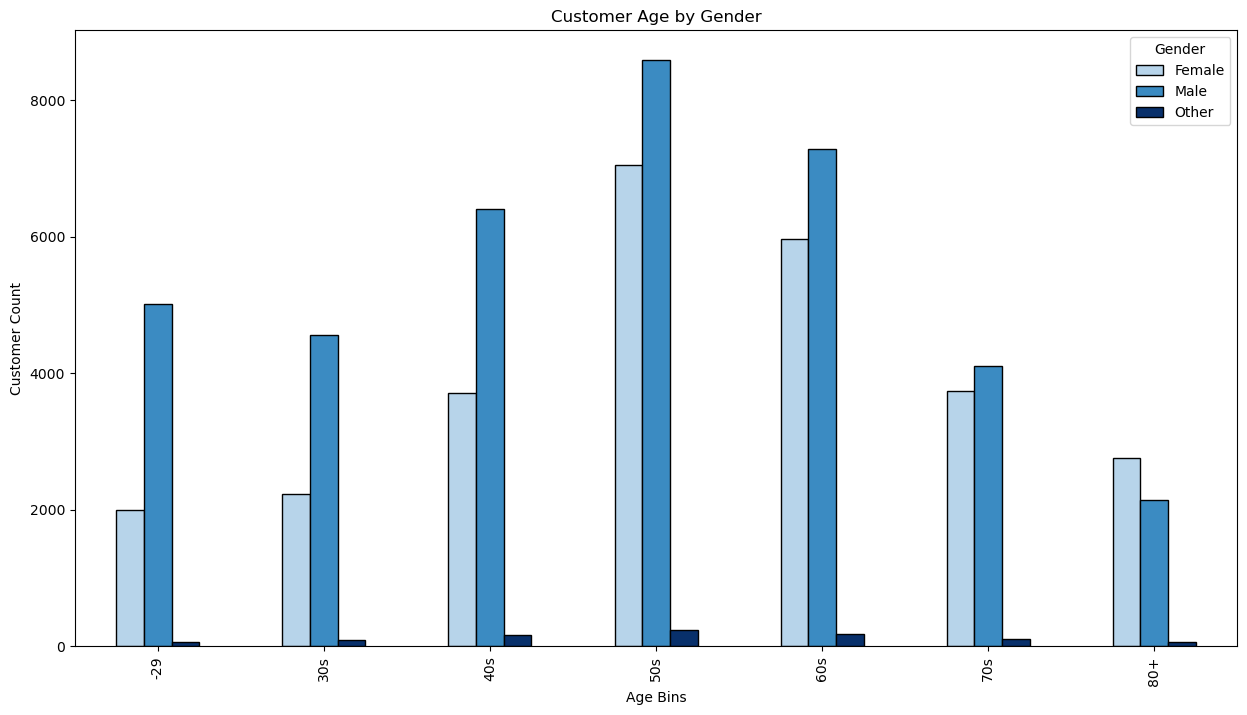

In [539]:
colors = plt.cm.Blues(np.linspace(0.3, 1, 3))
pd.crosstab(person_offer_df.age_bins,person_offer_df.gender).plot(kind='bar', figsize=(15,8), edgecolor = 'k', title='Customer Age by Gender',color=colors)
plt.xlabel('Age Bins')
plt.ylabel('Customer Count')
plt.legend(title='Gender',labels=['Female','Male','Other'])
plt.show();

**Observation:** The age structure of the customers has a focus on the 50s. The proportion of male customers is higher than that of females or others. However, the proportion of male customers compared with women decreases with increasing age. However, this corresponds to the demographic distribution.

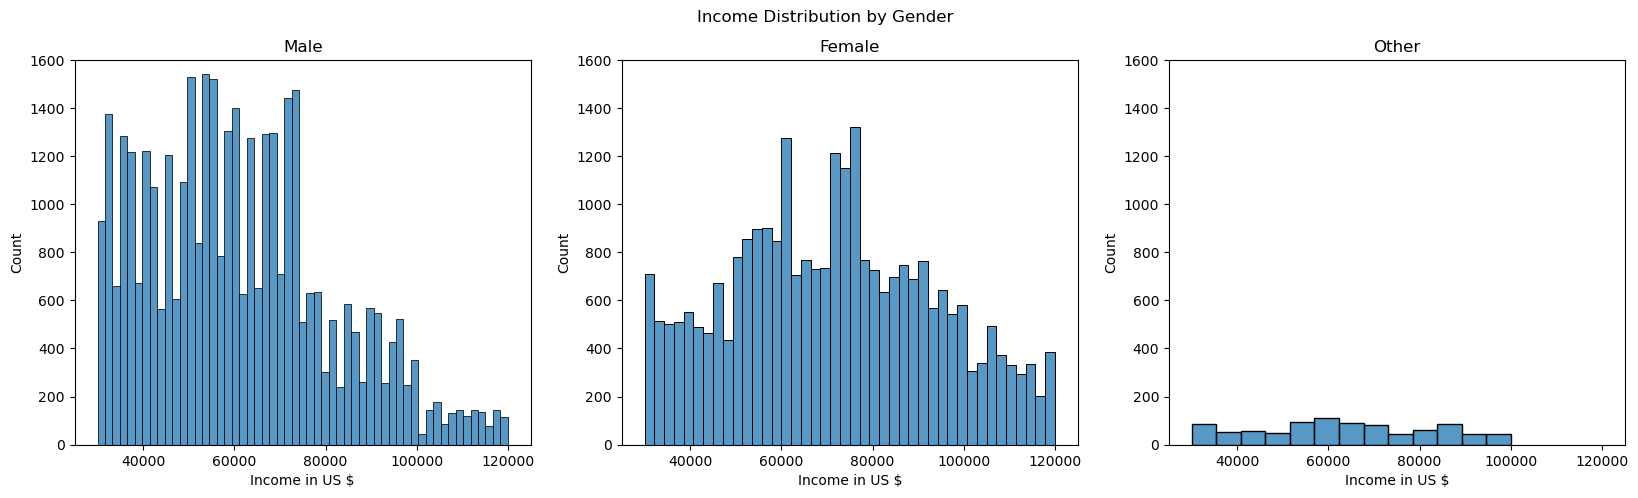

In [540]:
colors = plt.cm.Blues(np.linspace(0.3, 1, 3))
fig, ax = plt.subplots(1, 3, figsize = [20, 5])
sns.histplot(data=person_offer_df.query('gender =="M"'), x='income',ax=ax[0])
ax[0].set_title('Male')
sns.histplot(data=person_offer_df.query('gender =="F"'), x='income',ax=ax[1])
ax[1].set_title('Female')
sns.histplot(data=person_offer_df.query('gender =="O"'), x='income',ax=ax[2])
ax[2].set_title('Other')
for i in range(3):
    ax[i].set_ylim(0,1600)
    ax[i].set_xlim(25000,125000)
    ax[i].set_xlabel('Income in US $')
#plt.xlabel('Age Bins')
#plt.ylabel('Customer Count')
#plt.legend(title='Gender',labels=['Female','Male','Other'])
plt.suptitle('Income Distribution by Gender')
plt.show();

#### Distribution of membership duration

Text(0, 0.5, 'Count of Customers')

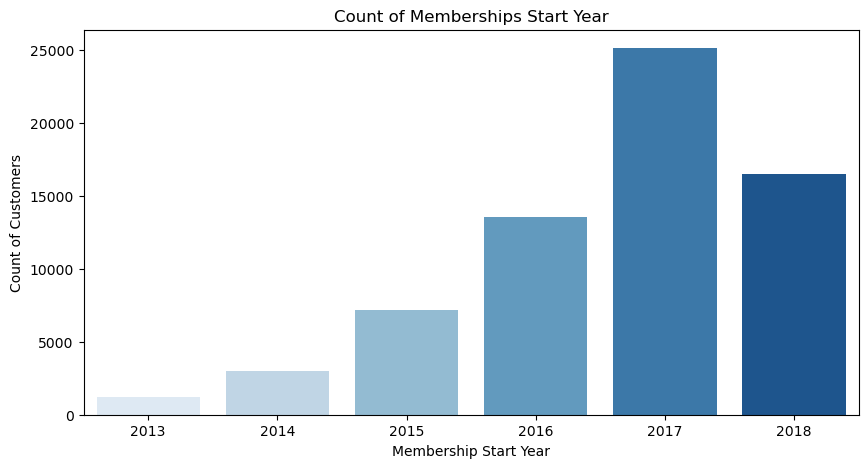

In [541]:
plt.figure(figsize = (10,5))
blues_palette = sns.color_palette("Blues")
sns.countplot(x='became_member_year', data=person_offer_df,palette=blues_palette)
plt.title('Count of Memberships Start Year')
plt.xlabel('Membership Start Year')
plt.ylabel('Count of Customers')



**Observation:** Most customers have been members for a relatively short time. In 2018 there was a peak in new memberships

#### Offer success by age

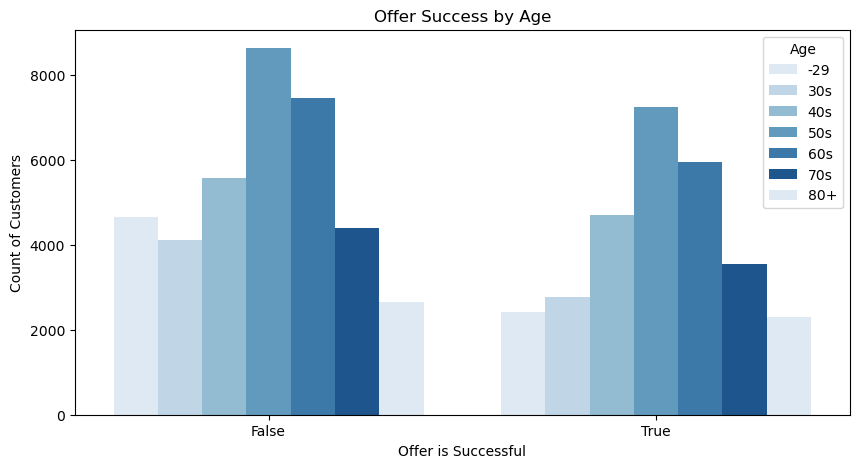

In [542]:
plt.figure(figsize = (10,5))
sns.countplot(x='success',hue='age_bins',data=person_offer_df,palette=blues_palette)
plt.title('Offer Success by Age')
plt.xlabel('Offer is Successful')
plt.ylabel('Count of Customers')
plt.legend(title='Age');

**Observation:** Basically, the distribution of the success of an offer looks quite similar to the basic age distribution of customers. What is striking, however, is that the offers seem to be less successful with customers below 50. 

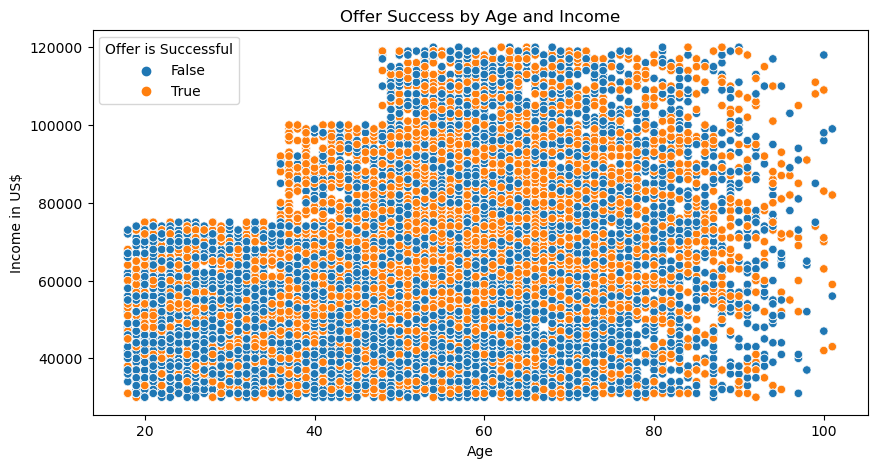

In [543]:
plt.figure(figsize = (10,5))
sns.scatterplot(data=person_offer_df, x="age", y="income", hue="success")
plt.title('Offer Success by Age and Income')
plt.xlabel('Age')
plt.ylabel('Income in US$')
plt.legend(title='Offer is Successful');

**Observation:** It looks like customers below an age of about 35 and customers with an income below 50Tsd  or above 100Tsd US dollars are not so receptive for offers like customers that are not in this group.

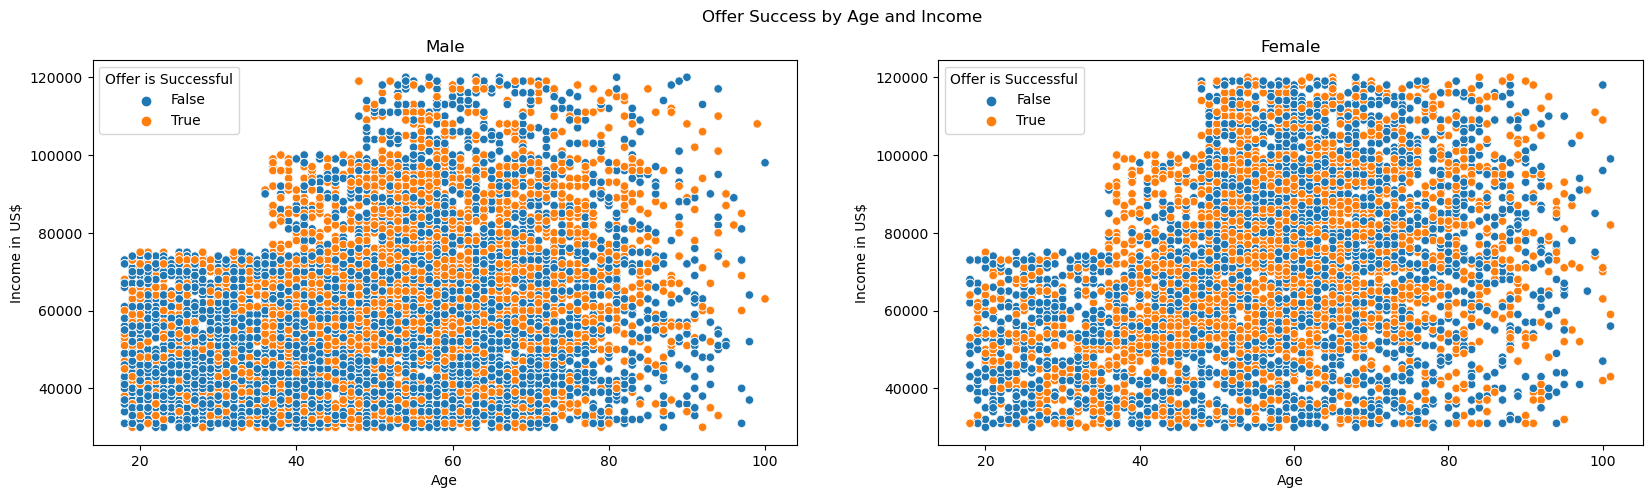

In [544]:

fig, axes = plt.subplots(1,2, figsize = (20,5))
gender_names = ["M","F"]
gender_titles = ['Male','Female']
for gender_name, gender_title, ax in zip(gender_names, gender_titles, axes.flatten()):
    sns.scatterplot(data=person_offer_df.query('gender==@gender_name'), x="age", y="income", hue="success", ax=ax)
    ax.set_xlabel('Age')
    ax.set_ylabel('Income in US$')
    ax.legend(title='Offer is Successful')
    ax.set_title(gender_title) 
plt.suptitle('Offer Success by Age and Income')
plt.show();
#plt.tight_layout()

**Observation:** The above statement on distribution applies more strongly to men than to women. For women, the distribution of successful offers is much more evenly distributed across age and income groups.

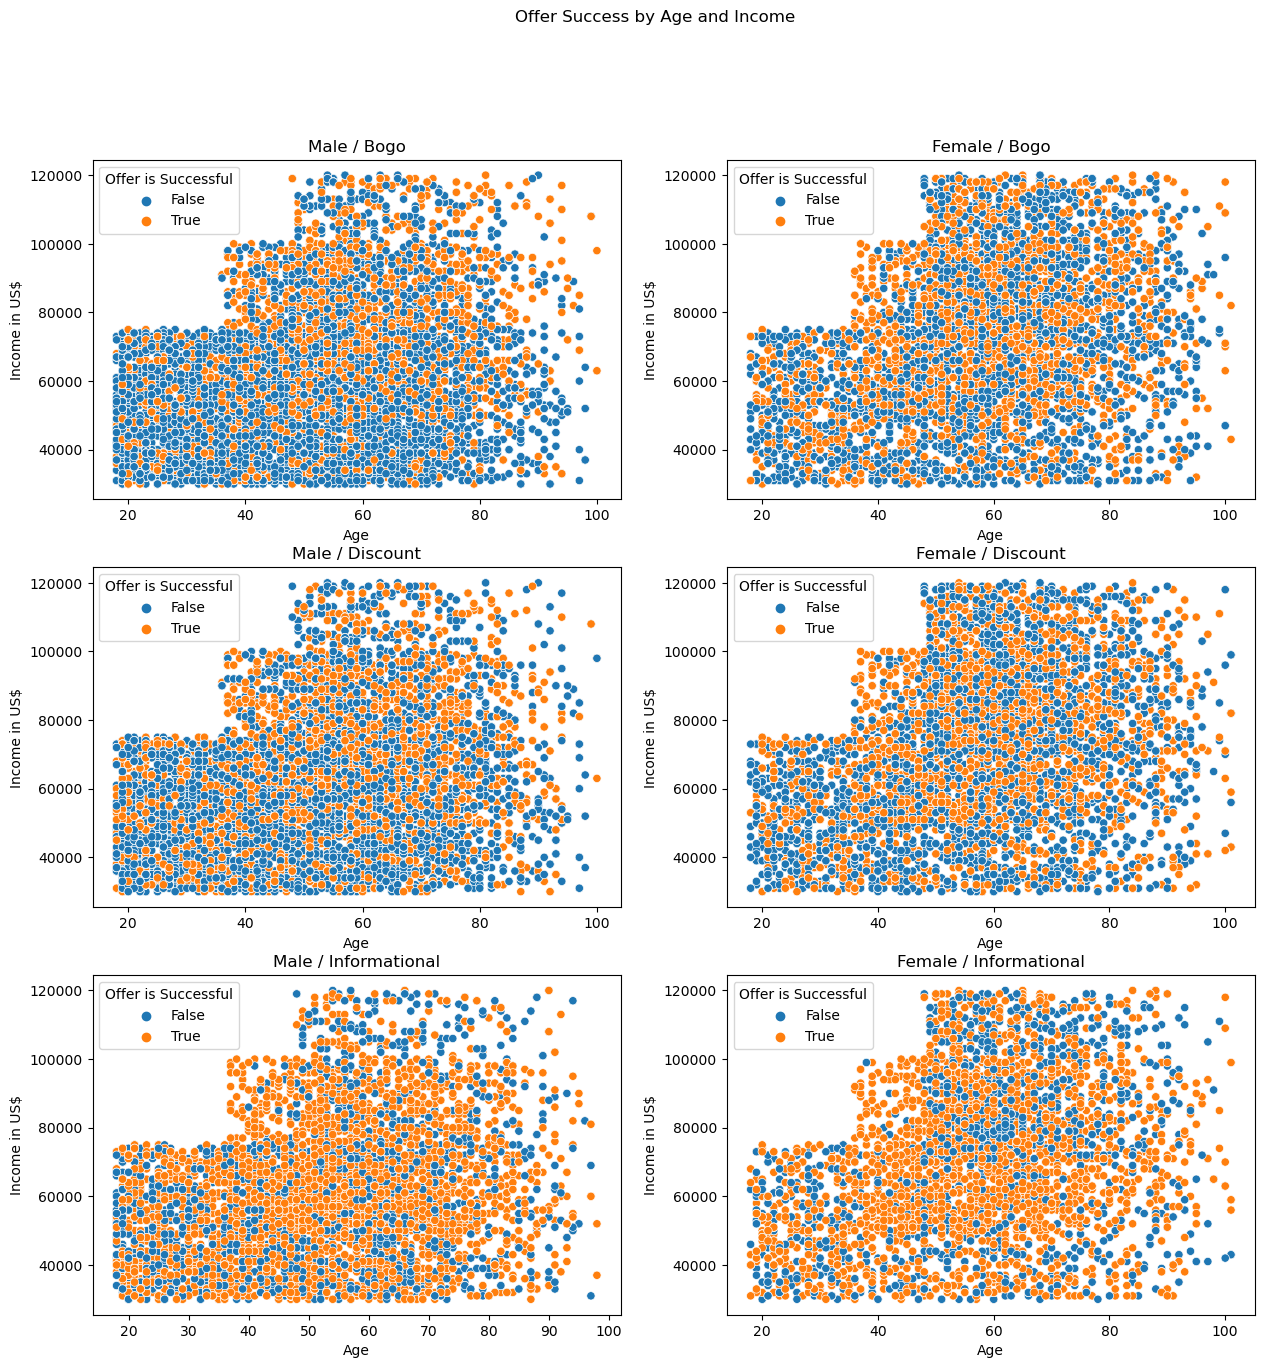

In [545]:
fig, axes = plt.subplots(3,2, figsize = (15,15))
gender_names = ["M","F"]
offer_types = ["bogo","discount","informational"]
gender_titles = ['Male','Female']
line= 0
for o_type in offer_types:
    col = 0
    for gender_name, gender_title, in zip(gender_names, gender_titles):
        ax = axes[line,col]
        sns.scatterplot(data=person_offer_df.query('gender==@gender_name & offer_type == @o_type'), x="age", y="income", hue="success", ax=ax)
        ax.set_xlabel('Age')
        ax.set_ylabel('Income in US$')
        ax.legend(title='Offer is Successful')
        tit = gender_title + " / " + o_type.capitalize()
        ax.set_title(tit) 
        col += 1
    line +=1
plt.suptitle('Offer Success by Age and Income')
plt.show();

**Oberservation:** The success rate for discount offers is much higher than for bogo offers. Comparing males to females the success rate of both offer types is higher for females than for males. Females seem to be more sensitive for offers. Regarding informational offers there is a different picture. Informational offers have a high success rate both for males and females, but look more successful for males than for females.

## 3) Modeling

The target is to build a model that predicts whether an offer is successful or not based on the demographic features of a customer and the features of the offer like channels, reward, minimum amount to spent.
What is a successful offer?
This means for bogo and discount offers the customer follows the the funnel offer received / offer viewed / offer completed and for an informational offer offer received / offer viewed.
These offers are marked as successful in the dataset.
There are also other offers in the dataset, e.g. with the funnel where the viewing is after the offer completion. This means that the customer was not influenced by the offer when making the purchase decision, but also gained the reward. So from a Starbucks view the reward could be saved. Offers like these are marked as not successful in the dataset.

So the target for the model is the offer success.

Problems like tis are typical problems for classifiers. Scikit learn offers different models which appear to be fundamentally suitable for this problem: 

* DecisionTreeClassifier
* RandomForestClassifier
* AdaBoostClassifier
* Gaussian Naive Bayes

In order to find out which model is most suitable for the task, all models are tested and the results are compared with each other so that the best model for the data set and the task can be determined.

For the resulting target model, gridsearch is subsequently used to determine the parameters that provide the best results.

### 3a) Prepare the data for the model (One Hot Encoding)

In [546]:
person_offer_df.head()

,customer_id,offer_id,success,gender,age,age_bins,income,income_bins,became_member_year,offer_type,reward,minimum_spent,duration_days,channel_email,channel_social,channel_mobile,channel_web
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,True,M,33,30s,72000.0,70-80Tsd,2017,informational,0,0,3,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,True,M,33,30s,72000.0,70-80Tsd,2017,informational,0,0,4,1,0,1,1
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,False,M,33,30s,72000.0,70-80Tsd,2017,bogo,5,5,5,1,1,1,1
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,False,M,33,30s,72000.0,70-80Tsd,2017,discount,2,10,10,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,False,M,33,30s,72000.0,70-80Tsd,2017,discount,2,10,7,1,0,1,1


In [547]:
# change boolean to int for success
person_offer_df.success = (person_offer_df.success == True).astype(int)

#dummy the column gender
person_offer_df = pd.get_dummies(person_offer_df, columns=['gender'])
person_offer_df.rename(columns={'gender_F': 'gender_female','gender_M':'gender_male','gender_O':'gender_others'}, inplace=True)
#person_offer_df.drop(['gender'], axis = 1,inplace = True)

#dummy the column offer_type
person_offer_df = pd.get_dummies(person_offer_df, columns=['offer_type'])
#person_offer_df.drop(['offer_type'], axis = 1,inplace = True)

In [548]:
#delete the not needed columns customer_id, offer_id, age_bins
person_offer_df.drop(['customer_id','offer_id','age_bins','income_bins'], axis = 1,inplace = True)


### 3b) Create the models and calculate the accuracy

In [549]:
model_df = person_offer_df.copy()

#see https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html ,
# https://scikit-learn.org/stable/modules/model_evaluation.html

# extract the target data from the model dataframe => success column,
# which indicates whether the offer was successful or not
target = model_df['success']

# get a dataframe with the features by deleting the column with the target from the model dataframe
feature_df = model_df.drop(['success'], axis = 1)

In [550]:
# check weather the target is balanced or not
num_positive_examples = (target == 1).sum()
num_total_examples = len(target)
positive_example_ratio = num_positive_examples / num_total_examples
print(positive_example_ratio)

0.4353026131696529


**Observation:** With a ratio of 0,44 for the positives vs the negatives the target vector is not inbalanced. Normally a target vector is classified as inbalanced when the ration is 1:10 or 1:20. 
For an inbalanced vector the F1 score should be used and not the accuracy score. Here the accuracy score can be used as a metric to measure the claasification power of the model.
To get a better view on the models the accuracy score as well as the F1 score is calculated.  

In [551]:
#define the models to test

classifier_names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes"
]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
]


acc_train_scores = []
acc_test_scores = []
acc_scores_diff = []
f1_train_scores = []
f1_test_scores = []
f1_scores_diff = []

# split the data into train and test data using sklearn
X_train, X_test, y_train, y_test = train_test_split(feature_df, target, test_size = 0.4, random_state=42)

# iterate over classifiers
for name, clf in zip(classifier_names, classifiers):

    # setup a pipeline
    clf = make_pipeline(StandardScaler(), clf)

    #fit the model
    clf.fit(X_train, y_train)

    # make a prediction on the test and train data
    test_prediction = clf.predict(X_test)
    train_prediction = clf.predict(X_train)

    # calculate the accuracy score of the prediction for the test and train data 
    test_accuracy_score = accuracy_score(y_test , test_prediction)
    train_accuracy_score = accuracy_score(y_train , train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    train_f1_score = f1_score(y_train, train_prediction)

    # save the results 
    acc_test_scores.append(test_accuracy_score)
    acc_train_scores.append(train_accuracy_score)
    acc_scores_diff.append(train_accuracy_score - test_accuracy_score)
    f1_test_scores.append(test_f1_score)
    f1_train_scores.append(train_f1_score)
    f1_scores_diff.append(train_f1_score - test_f1_score)
    

In [552]:
data = {'Model':classifier_names, 'Train Accuracy':acc_train_scores,'Test Accuracy':acc_test_scores, 'Accuracy Difference':acc_scores_diff,
        'Train F1 Score': f1_train_scores, 'Test F1 Score': f1_test_scores, 'F1 Difference': f1_scores_diff}

accuracy_df = pd.DataFrame(data)


<Figure size 1200x800 with 0 Axes>

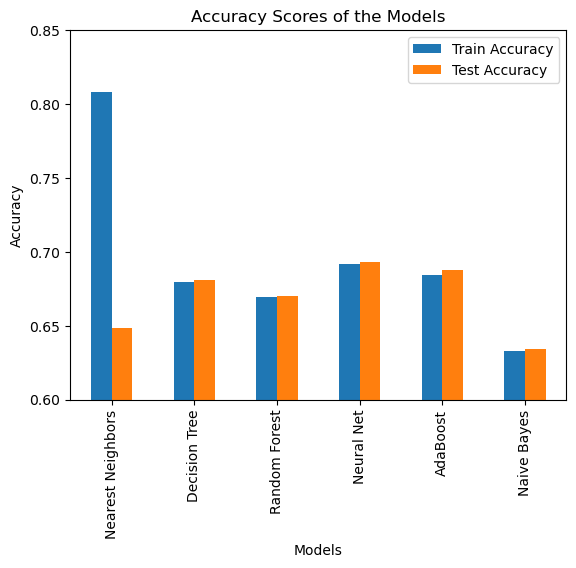

In [553]:
plt.figure(figsize=(12,8))
accuracy_df.plot(x="Model", y=["Train Accuracy", "Test Accuracy"], kind="bar")
plt.ylim(0.6, 0.85)  
plt.title('Accuracy Scores of the Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show();

<Figure size 1200x800 with 0 Axes>

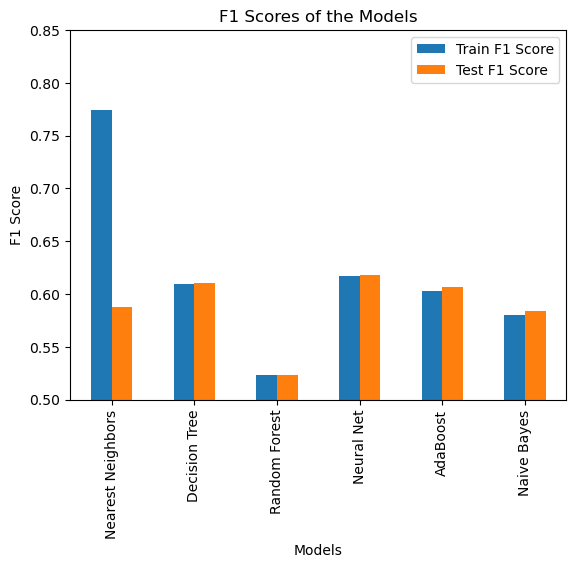

In [554]:
plt.figure(figsize=(12,8))
accuracy_df.plot(x="Model", y=["Train F1 Score", "Test F1 Score"], kind="bar")
plt.ylim(0.5, 0.85)  
plt.title('F1 Scores of the Models')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.show();

**Observation:** The nearest neighbors model has the best train accuracy, but the difference between train and test accuracy is the highest of all model, which leads not to good predictions. The MLP classifier has the best accuracy for both train and test as well as only a small difference between the two values. So the MLP classifier is choosen as prediction model. 

### 3c) Hyperparameter tuning - Improve the model with GridSearchCV

In [555]:
# Define the parameters for Gridsearch with the MLP Classifier
RANDOM_SEED = 5
split = 5

GRID = [
    {'scaler': [StandardScaler()],
     'estimator': [MLPClassifier(random_state=RANDOM_SEED)],
     'estimator__solver': ['adam'],
     'estimator__max_iter': [4000],
     'estimator__learning_rate_init': [0.0001],
     'estimator__activation': ['tanh', 'relu'],
     'estimator__alpha': [0.0001, 0.005],
     'estimator__early_stopping': [True, False]
     }
]

# Setup a pipeline
PIPELINE = Pipeline([('scaler', None), ('estimator', MLPClassifier())])

# execute gridsearch
grid_search = GridSearchCV(estimator=PIPELINE, param_grid=GRID, 
                            scoring=make_scorer(accuracy_score),# average='macro'), 
                            n_jobs=-1, cv=split, refit=True, verbose=1, 
                            return_train_score=False)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', None),
                                       ('estimator', MLPClassifier())]),
             n_jobs=-1,
             param_grid=[{'estimator': [MLPClassifier(learning_rate_init=0.0001,
                                                      max_iter=4000,
                                                      random_state=5)],
                          'estimator__activation': ['tanh', 'relu'],
                          'estimator__alpha': [0.0001, 0.005],
                          'estimator__early_stopping': [True, False],
                          'estimator__learning_rate_init': [0.0001],
                          'estimator__max_iter': [4000],
                          'estimator__solver': ['adam'],
                          'scaler': [StandardScaler()]}],
             scoring=make_scorer(accuracy_score), verbose=1)

In [556]:
clf = grid_search.best_estimator_
#fit the model
clf.fit(X_train, y_train)

# make a prediction on the test and train data
test_prediction = clf.predict(X_test)
train_prediction = clf.predict(X_train)

# calculate the accuracy score of the prediction for the test and train data 
test_accuracy_score = accuracy_score(y_test , test_prediction)
train_accuracy_score = accuracy_score(y_train , train_prediction)

print(test_accuracy_score, train_accuracy_score)

0.6938207529429463 0.6945990672483827
